# Advances in Machine Learning with Big Data

### Trinity 2021
### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os
from mpl_toolkits.mplot3d import axes3d
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

import numpy as np  
import pandas as pd  

#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import model_selection

import sbs_sklearn    # module where I've put some functions from the last class
from uci_retail_data import uci_files, stock_codes

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_coeffs(mod, mod_name, comment):
    plt.plot(mod.coef_, marker='o')
    plt.grid()
    plt.title(f"The betas of the {mod_name} - {comment}")
    plt.axhline(color='k')

## 6. Classification

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. **Classification**

1. Decision trees, bagging, and random forests

1. Single-layer neural networks

Load data per previous classes ...

In [3]:
df = uci_files.standard_uci_data_access()

2021-05-05 14:37:20,234 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2021-05-05 14:37:23,401 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [4]:
invalids = stock_codes.invalid_series(df)

In [5]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

2021-05-05 14:37:23,763 INFO:NumExpr defaulting to 8 threads.


### Instead of a regression problem, lets prepare our dataset for a classification problem:

In [6]:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

# predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']   # commented-out: this was the regression setup
predictors = ['log_n_codes', 'log_item_spend', 'month', 'words_per_item']

# y = invoices.log_item_spend   # commented-out: this was the regression setup
y = invoices.hour
X = invoices[predictors] 

*Can we predict the hour of the day from characteristics of the basket?*

In [7]:
from sklearn import preprocessing
poly = preprocessing.PolynomialFeatures(4, include_bias=False)
polynomial_X = pd.DataFrame(poly.fit_transform(X.values))
polynomial_X.columns = poly.get_feature_names(X.columns)

In [8]:
poly_std_X = ((polynomial_X - polynomial_X.mean()) / polynomial_X.std())

### What do we actually do when we predict $y$?

* We form a distribution, conditional on regressors.
* This is not that helpful if we want to *act*!

### How about when we *classify* $y$?

* We pick one object from a set. And act on it.

We have a finite (maybe countable) set of categories, $\mathcal C$, from which $y$ is drawn.

In [9]:
print(f"The categories we need to pick from are {set(y)}")

The categories we need to pick from are {7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


#### **Supervised learning**:  we have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in the distribution of the R.V. $y_i$, conditional on the stacked regressors, namely $x$:
\begin{equation}
y_i | x \ \ \sim \ \ \mathcal f_{x_i; \theta},
\end{equation}

where the $\theta$ is just to remind us there are parameters.

#### Recall, in the **linear regression:**
\begin{equation}
\mathcal f_{x_i; \theta} \ \sim \ \mathcal N ( x_i ' \beta, \sigma^2).
\end{equation}

#### But, today we're looking at a **categorical model**: 

* $f_{x_i; \theta}$ is simply a discrete distribution that depends on data $x_i$ and the parameters $\theta$. 

#### But, today we're looking at a **categorical model**: 

* $f_{x_i; \theta}$ is simply a discrete distribution that depends on data $x_i$ and the parameters $\theta$. 

In [10]:
hist_opts = dict(bins=len(set(y)), 
                 alpha=0.2, 
                 density=True, 
                 title="Non-parametric histogram, giving the distribution of hours when $x_i$'s month is Feb 2010")

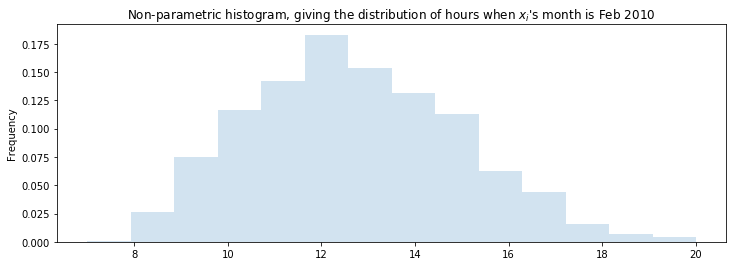

In [11]:
_ = y.loc[X.month == 201002].plot.hist(**hist_opts)

If we want to write more about it, we could use dummies, $y$ and $j$, to say:

\begin{equation}
\mathcal f_{x_i; \theta}(y) \ \ \ \ = \ \ \ \ \text{Pr}(y = j \  | \ x_i \ ; \ \theta) \ \ \ , \text{  for all } j \in \mathcal C.
\end{equation} 

In [12]:
hist_opts.update(dict(title="There's potentially a different histogram for each possible $x_i$ (here I bin by month)"))

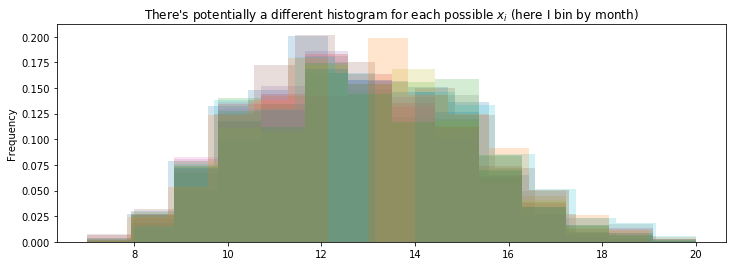

In [13]:
for month in set(X.month): y.loc[X.month == month].plot.hist(**hist_opts)

### The Bayes Classifier:

Introduction to Statistical Learning 2.2.3:

* the *test error rate* is minimized, on average, if one *assigns each observation to the most likely class, given its predictor values*.

So, speaking 'graphically' ...

imagine the perfect situation where you know $\theta$. 

Then to classify observation $i$, select the appropriate histogram for the $x_i$, and take its highest (modal) point.

Comments: 

* There's no concept of type-1 or type-2 error generally because possibly $|\mathcal C | > 2$
* Even though it's perfect, the Bayes Classifier still get lots wrong.
   * this is like how a regression's point-estimates are almost always wrong

#### Bayes Classification when we're fitting models

As before, we will have to postulate a model, $\hat f_{x_i; \theta}$, and then we will have to fit $\hat \theta$.

Next, we simply copy Bayes Classification, so to classify observation $i$, obtain from the model the histogram for $x_i$, and take its highest (modal) point.

### [Multinomial Logit](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#Model)

For each $k \in \mathcal C$, have a coefficient vector $\beta_k$.
* that can be a lot of coefficients ...

Given features $x_i$, form a score for each possibility $k$:
\begin{equation}
\text{score}(x_i, k) = \beta_k ' x_i
\end{equation}

We would *love* to use this score to model the log-probability of $k$ given $x_i$:

\begin{equation}
\text{  Pr}(y_i = k \  | \ x_i \ ; \ \beta) = e^{\text{score}(x_i, k)}
\end{equation} 

But probabilities must add to one! So, adjust this approach slightly by using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). Worth reading-up on this - it just adds the right normalization.

Create our learner:

In [14]:
logistic = linear_model.LogisticRegression()

Do a 25-fold split of the data:

In [15]:
N_FOLDS = 50
kfold = model_selection.KFold(n_splits=N_FOLDS, shuffle=True)
train, test = next(kfold.split(poly_std_X, y))

**Fitting the model** means maximizing a regularized likelihood:

In [16]:
logistic.fit(poly_std_X.values[train], y.values[train])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

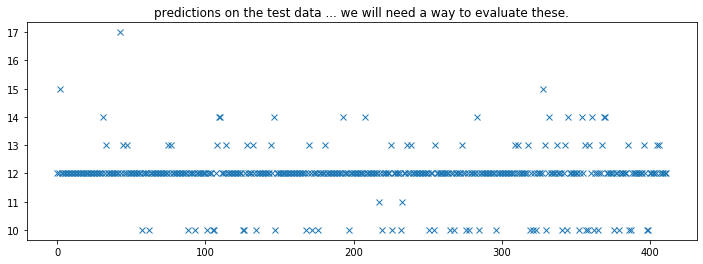

In [17]:
plt.plot(logistic.predict(poly_std_X.values[test]), ls='None', marker = 'x')
_ = plt.title('predictions on the test data ... we will need a way to evaluate these.')

In [18]:
logistic.coef_.shape

(14, 69)

Further references:
* [Scikit-learn docstring](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [Scikit-learn theory](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* [Categorical cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood)

### Confusion matrix

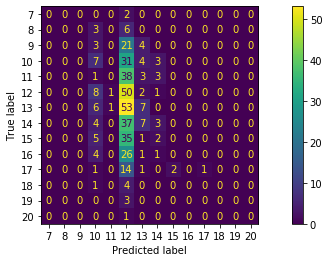

In [19]:
from sklearn import metrics
_ = metrics.plot_confusion_matrix(logistic, poly_std_X.values[test], y.values[test])

The proportion of observations that lie on the diagonal is the [Accuracy Score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

But this is (perhaps the leading) one of [several metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) that in use.

In [20]:
print(metrics.classification_report(logistic.predict(poly_std_X.values[test]), y.values[test]) )

              precision    recall  f1-score   support

           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.16      0.16      0.16        43
          11       0.00      0.00      0.00         2
          12       0.81      0.16      0.26       321
          13       0.10      0.23      0.14        30
          14       0.06      0.23      0.09        13
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          17       0.05      1.00      0.10         1
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0

    accuracy                           0.17       412
   macro avg       0.08      0.13      0.05       412
weighted avg       0.65      0.17      0.23       412



#### The Bayes Classifier when $|\mathcal C| = 2$

Example: COVID-19 test. $\mathcal C =$ {positive, negative}.

*Exercise*: Show that Bayes Classifier must pick 'positive' iff:
\begin{equation}
\text{Pr}(y = \text{'positive'} \  | \ x_i \ ; \ \theta) > T,
\end{equation} 
where $T= 0.5$.

As we know, this minimizes the error rate.
 * But, maybe we care more about false negatives (sensitivity, recall) than false positives (specificity).
 * -> some types of error matter more.
 
Solution?

* Vary $T$, sliding it up and down within the interval (0, 1). I.e. depart from Bayes.
* for each such $T$, one could record the False-Positive Rate, and the True-Positive Rate.

This gives rise to the [Receiver operating characteristic (ROC) Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:Roc-draft-xkcd-style.svg)

### Evaluating a classification model

[Scikit learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)